In [194]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [195]:
plt.style.use('seaborn-darkgrid')

In [196]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [197]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [198]:
# 1 point
def scale(X):
    X = np.array(X)
    return (X-X.mean(axis=0))/X.std(axis=0)

In [201]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [202]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self,  copy=True, with_mean=True, with_std=True):
       pass
    def fit(self, X, y=None):
        self.X_mean = np.array(X).mean(axis=0)
        self.X_std = np.array(X).std(axis=0)
        return self

    def transform(self, X, y=None, copy=None):
        X = np.array(X)
        return (X - self.X_mean) / self.X_std

In [203]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [204]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ 17.89564068,  -1.34135934],
       [  8.88855393,   0.87952592],
       [  2.01957676,  -0.8520019 ],
       ...,
       [-10.1498306 ,   4.39415262],
       [  6.865815  ,   5.83303726],
       [ -2.25085713,   4.02428537]])

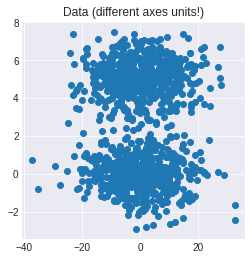

In [205]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

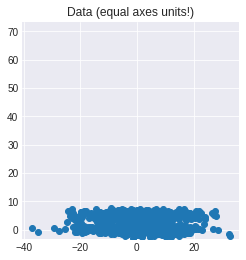

In [206]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

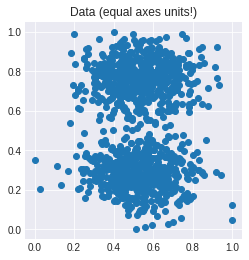

In [207]:
min_max_scale = MinMaxScaler()
min_max_scaler = min_max_scale.fit_transform(data)
plot_scatter(min_max_scaler[:, 0], min_max_scaler[:, 1], auto_scaled=False , title='Data (equal axes units!)')

### StandardScaler (0.5 point)

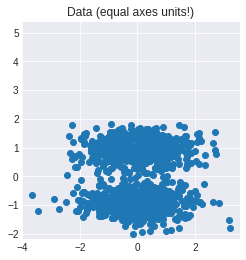

In [208]:
### StandardScaler (0.5 point)
std_scale = StandardScaler()
std_scaler = std_scale.fit_transform(data)
plot_scatter(std_scaler[:, 0], std_scaler[:, 1], auto_scaled=False , title='Data (equal axes units!)')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


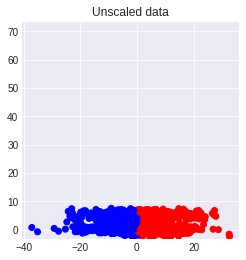

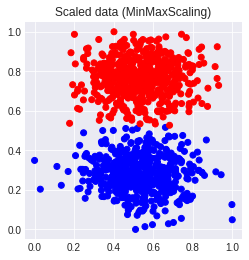

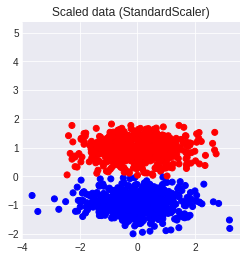

In [209]:
## your code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=2)
Kmean.fit(data)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,  random_state=None, tol=0.0001, verbose=0)
km = KMeans(2)


clusters = km.fit_predict(data)
plot_scatter(data[:, 0], data[:, 1],  auto_scaled=False , title='Unscaled data', clusters = clusters)

clusters = km.fit_predict(min_max_scaler)
plot_scatter(min_max_scaler[:, 0], min_max_scaler[:, 1], auto_scaled=False, title='Scaled data (MinMaxScaling)', clusters = clusters)

clusters = km.fit_predict(std_scaler)
plot_scatter(std_scaler[:, 0], std_scaler[:, 1], auto_scaled=False, title='Scaled data (StandardScaler)',  clusters = clusters )



In [210]:
Kmean.cluster_centers_

array([[-7.77769229,  2.53371263],
       [ 8.3611443 ,  2.55141568]])

## Exercise  3 - Preprocessing Pipeline (2 points)

In [211]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [213]:
model = LogisticRegression(solver='liblinear', penalty='l1')

# Base model
model.fit(wine_train, wine_labels_train)
pred = model.predict(wine_val)
print('Base Model_train:  ', accuracy_score(wine_labels_train, model.predict(wine_train)))
print('Base Model:  ', accuracy_score(wine_labels_val, pred))

# + StandardScaler
model_scaling = make_pipeline(StandardScaler(), model)
model_scaling.fit(wine_train, wine_labels_train)
pred_scaled = model_scaling.predict(wine_val)
print('StandardScaler Model_train:  ', accuracy_score(wine_labels_train, model_scaling.predict(wine_train)))
print('StandardScaler Model:  ', accuracy_score(wine_labels_val, pred_scaled))


# + Feature selection (StandardScaler + SelectFromModel)
model_selection = make_pipeline(StandardScaler(),
                                SelectFromModel(model ,max_features=len(wine_train.columns)),
                                model
                                )
model_selection.fit(wine_train, wine_labels_train)
pred_selected = model_selection.predict(wine_val)
print('StandardScaler Model + SelectFromModel_train:  ', accuracy_score(wine_labels_train, model_selection.predict(wine_train)))
print('StandardScaler Model + SelectFromModel :  ', accuracy_score(wine_labels_val, pred_selected))


# + MinMaxScaler
mm_model_scaling = make_pipeline(MinMaxScaler(), model)
mm_model_scaling.fit(wine_train, wine_labels_train)
mm_pred_scaled = mm_model_scaling.predict(wine_val)
print('MinMaxScaler Model_train:  ', accuracy_score(wine_labels_train, mm_model_scaling.predict(wine_train)))
print('MinMaxScaler Model:  ', accuracy_score(wine_labels_val, mm_pred_scaled))


# + Feature selection (MinMaxScaler + SelectFromModel)
model_selection = make_pipeline(MinMaxScaler(),
                                SelectFromModel(model ,max_features=len(wine_train.columns)),
                                model
                                )
model_selection.fit(wine_train, wine_labels_train)
pred_selected = model_selection.predict(wine_val)
print('MinMaxScaler Model + SelectFromModel_train:  ', accuracy_score(wine_labels_train, model_selection.predict(wine_train)))
print('MinMaxScaler Model + SelectFromModel :  ', accuracy_score(wine_labels_val, pred_selected))


Base Model_train:   0.967741935483871
Base Model:   0.9814814814814815
StandardScaler Model_train:   1.0
StandardScaler Model:   0.9814814814814815
StandardScaler Model + SelectFromModel_train:   1.0
StandardScaler Model + SelectFromModel :   0.9814814814814815
MinMaxScaler Model_train:   0.967741935483871
MinMaxScaler Model:   1.0
MinMaxScaler Model + SelectFromModel_train:   0.967741935483871
MinMaxScaler Model + SelectFromModel :   1.0


## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [214]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [215]:
scaler = StandardScaler()
scaled_wine_data = scaler.fit_transform(wine_data)
S = np.cov(scaled_wine_data.T)

If your code is correct, the following assert should be Ok.

In [216]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [217]:
from scipy.optimize import minimize

def objective(x):
    # your code: write objective of the problem (don't forget that scipy does min while we need max)
    return 1- x.T @ S @ x


def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    if np.linalg.norm(x) == 1:
        return 0
    else:
        return 1- x.T @ x
con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.ones(wine_data.shape[1])

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [218]:
def orthogonality_constraint(x):
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds
    if x.T @ x0 == 0:
        return 0
    else:
        return - x.T @ x0
con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.ones(wine_data.shape[1])


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2]
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [219]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

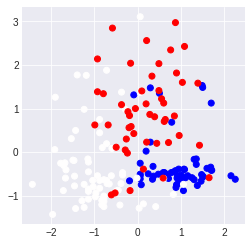

In [220]:
plot_scatter(scaled_wine_data[:, 0], scaled_wine_data[:, 1], clusters=wine_labels, auto_scaled=True)

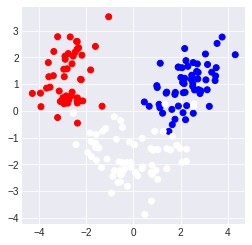

In [221]:
plot_scatter(scaled_wine_data @ x0, scaled_wine_data @ x1, clusters=wine_labels, auto_scaled=True)


## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [237]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

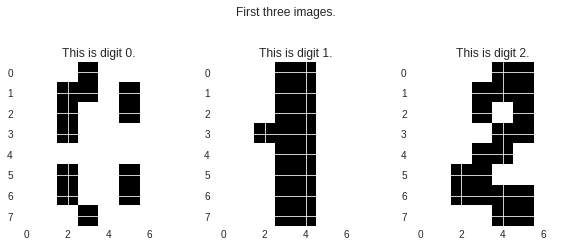

In [238]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [239]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [240]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [241]:
clf = RandomForestClassifier(max_depth=13)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(acc)

0.9876543209876543


In [227]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [242]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

# # your code here: do run the boruta
# feat_selector.fit(np.array(X_train), y_train)
# y_pred = feat_selector.predict(np.array(X_val))
# ###Test Score
# feat_selector.score(X_val, y_val)
# ###Training Score
# feat_selector.score(X_train, y_train)

# find all relevant features
feat_selector.fit(np.array(X_train), np.array(y_train))

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a

array([25, 25,  1,  1,  1,  1, 25, 25, 25,  8,  1,  4,  2,  1, 13, 25, 25,
        7,  1,  1,  1,  1, 11, 25, 25,  9,  1,  1,  1,  1, 15, 25, 25, 25,
        1,  1,  1,  1, 11, 25, 25, 25,  1,  1,  1,  1,  6, 25, 25, 10,  1,
        1,  1,  1,  1, 14, 25, 25,  1,  1,  3,  1,  1,  5])

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

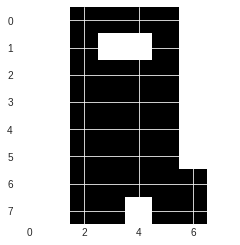

In [243]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

In [244]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(np.array(X_train))
X_val_filtered = feat_selector.transform(np.array(X_val))

At the end let us redo  classification but only with selected features

In [232]:
print('X_val: ', X_val.shape, 'X_val_filtered:', X_val_filtered.shape)

X_val:  (162, 64) X_val_filtered: (162, 31)


In [248]:
clf = RandomForestClassifier(max_depth=10)
clf.fit(X_filtered,y_train)
acc = accuracy_score(y_val, clf.predict(X_val_filtered))
print(acc)

0.9938271604938271


In [249]:
assert acc > 0.99